In [21]:
# Import required packages

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point
from numpy import trapz
from scipy.stats import gamma,norm
from sklearn.cluster import KMeans
import sys
from pathlib import Path
import logging

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))


In [2]:
# Configuration
config = {
    'casr_input_data': project_root / 'data' / 'output_data' / 'merged_2d' / '1980_2024'/'bow_combined_full_data.csv',
    'shapefile': project_root / 'data' / 'input_data' / 'shapefiles'/'BowRiverBasin'/'Bow_elevation_combined.shp',
    'canswe_original_data' : project_root / 'data' / 'output_data' / 'for_paper'/'FROSTBITE' / 'bow_canswe.nc',
    'gap_filled_canswe_data' : project_root / 'data' / 'output_data' / 'for_paper'/'FROSTBITE' /'bow_swe_gapfilled_data_only.nc',
    'output_dir': project_root / 'data' / 'output_data' / 'for_paper'/'datasets',
    'SWEI_output_dir': project_root / 'data' / 'output_data' / 'for_paper'/'SWEI',
    'classification_output_dir': project_root / 'data' / 'output_data' / 'for_paper'/'SD_classification',
    'SPI_output_dir': project_root / 'data' / 'output_data' / 'for_paper'/'SPI',
    'SPEI_output_dir': project_root / 'data' / 'output_data' / 'for_paper'/'SPEI',
    'SWEI_plots': project_root / 'data' / 'output_plots' / 'for_paper'/'SWEI',
    'classification_plots': project_root / 'data' / 'output_plots'/'for_paper'/'SD_classification',
    'SPI_plots': project_root / 'data' / 'output_plots' / 'for_paper'/'SPI',
    'SPEI_plots': project_root / 'data' / 'output_plots' /'for_paper'/'SPEI',
}

In [3]:
# Load data data
CaSR_data = pd.read_csv(config['casr_input_data'])

# Load shapefile for Bow Basin
bow_basin = gpd.read_file(config['shapefile'])

# Load original CanSWE data
canswe_data = xr.open_dataset(config['canswe_original_data'])

# Load gap-filled CanSWE data
gap_filled_canswe_data = xr.open_dataset(config['gap_filled_canswe_data'])

# CaSR dataframe
casr_data = CaSR_data[['time', 'Grid_id','lon', 'lat', 'SWE', 'Precipitation', 'Elevation_Category']].copy()
casr_data['time'] = pd.to_datetime(casr_data['time'])

display(bow_basin.head())

#Original CanSWE dataframe
canswe_df = canswe_data.to_dataframe().reset_index()
canswe_df['time'] = pd.to_datetime(canswe_df['time'])
display(canswe_df.head())

#Gap-filled CanSWE dataframe
gap_filled_canswe_df = gap_filled_canswe_data.to_dataframe().reset_index()
gap_filled_canswe_df['time'] = pd.to_datetime(gap_filled_canswe_df['time'])
display(gap_filled_canswe_df.head())


,PROVCD_1,VALDATE,EDITION,DATASETNAM,VERSION,COMPLEVEL,WSCMDA,WSCSDA,WSCSSDA,FDA,...,WSCSSDANAM,min,max,mean,count,std,median,PROVCD_2,elev_class,geometry
0,AB,20070208,1,05BM000,0,NHN-CL1,05,05B,05BM,05BM,...,Lower Bow - Crowfoot,776.0,1177.0,953.688214,9897452,71.132927,944.0,NaN,500_1000m,"POLYGON ((-112.58577 51.23024, -112.58519 51.2..."
1,AB,20070130,1,05BN000,0,NHN-CL1,05,05B,05BN,05BN,...,Lower Bow - Mouth,700.0,998.0,772.376015,9312616,32.852467,764.0,NaN,500_1000m,"POLYGON ((-112.49620 50.71881, -112.49566 50.7..."
2,AB,20070226,1,05BH000,0,NHN-CL1,05,05B,05BH,05BH,...,Central Bow - Jumpingpond,1038.0,2479.0,1259.913722,4121228,176.434021,1227.0,NaN,1000_1500m,"POLYGON ((-113.93263 51.12563, -113.93288 51.1..."
3,AB,20070228,1,05BK000,0,NHN-CL1,05,05B,05BK,05BK,...,Fish (Alta.),981.0,1777.0,1226.170423,1151005,126.086335,1194.0,NaN,1000_1500m,"POLYGON ((-114.10188 50.95504, -114.09750 50.9..."
4,AB,20070302,1,05BE000,0,NHN-CL1,05,05B,05BE,05BE,...,Upper Bow - Policeman,1146.0,3054.0,1601.837836,1655101,376.052387,1437.0,NaN,1500_2000m,"POLYGON ((-114.72215 51.33033, -114.72235 51.3..."


,station_id,time,lat,lon,elevation,source,station_name,station_name_sec,station_name_ter,station_id_sec,station_id_ter,type_mes,snw,snd,den,data_flag_snw,data_flag_snd,qc_flag_snw,qc_flag_snd
0,ALE-05BA811,1928-01-01,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''
1,ALE-05BA811,1928-01-02,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''
2,ALE-05BA811,1928-01-03,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''
3,ALE-05BA811,1928-01-04,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''
4,ALE-05BA811,1928-01-05,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''


,time,station_id,lat,lon,station_name,SWE
0,1980-01-01,ALE-05BA811,51.700001,-116.466667,BOW SUMMIT (OLD),NaN
1,1980-01-01,ALE-05BL801,50.599998,-114.983330,HIGHWOOD S. OPEN,NaN
2,1980-01-01,ALE-05BL808,50.483334,-114.866669,MOUNT ODLUM,NaN
3,1980-01-01,BCE-AL04,50.566666,-114.949997,STORM CREEK,NaN
4,1980-01-01,SCD-AL003,51.183334,-115.566666,BANFF,25.0


In [4]:
# Merge canswe_df and gap_filled_canswe_df
combined_canswe = pd.merge(
    canswe_df[['station_id', 'time', 'lat', 'lon', 'elevation', 'snw']],
    gap_filled_canswe_df[['station_id', 'time', 'lat', 'lon', 'SWE']],
    on=['station_id', 'time', 'lat', 'lon'],
    how='outer'
)

# Rename columns for clarity
combined_canswe.rename(columns={'snw': 'Original_CanSWE', 'SWE': 'Gap_Filled_CanSWE'}, inplace=True) 

# Select data 1980-2023
combined_canswe = combined_canswe[
    (combined_canswe['time'] >= '1980-01-01') & (combined_canswe['time'] <= '2024-07-31')
]

# Add Elevation_Category column to combined_canswe based on elevation
def categorize_elevation(elevation):
    if pd.isna(elevation):
        return None
    elif 500 <= elevation < 1000:
        return '500_1000m'
    elif 1000 <= elevation < 1500:
        return '1000_1500m'
    elif 1500 <= elevation < 2000:
        return '1500_2000m'
    elif 2000 <= elevation < 2500:
        return '2000_2500m'
    else:
        return None

combined_canswe['Elevation_Category'] = combined_canswe['elevation'].apply(categorize_elevation)

# Keep 1500-2000m and 2000-2500 elevation category only
combined_canswe = combined_canswe[
    combined_canswe['Elevation_Category'].isin(['1500_2000m', '2000_2500m'])
]

display(combined_canswe.head())

# Save combined CanSWE data
#output_dir = config['output_dir']
#output_dir.mkdir(parents=True, exist_ok=True)
#combined_canswe.to_csv(output_dir / 'bow_combined_canswe_gapfilled_data.csv', index=False)

,station_id,time,lat,lon,elevation,Original_CanSWE,Gap_Filled_CanSWE,Elevation_Category
18993,ALE-05BA811,1980-01-01,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m
18994,ALE-05BA811,1980-01-02,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m
18995,ALE-05BA811,1980-01-03,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m
18996,ALE-05BA811,1980-01-04,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m
18997,ALE-05BA811,1980-01-05,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m


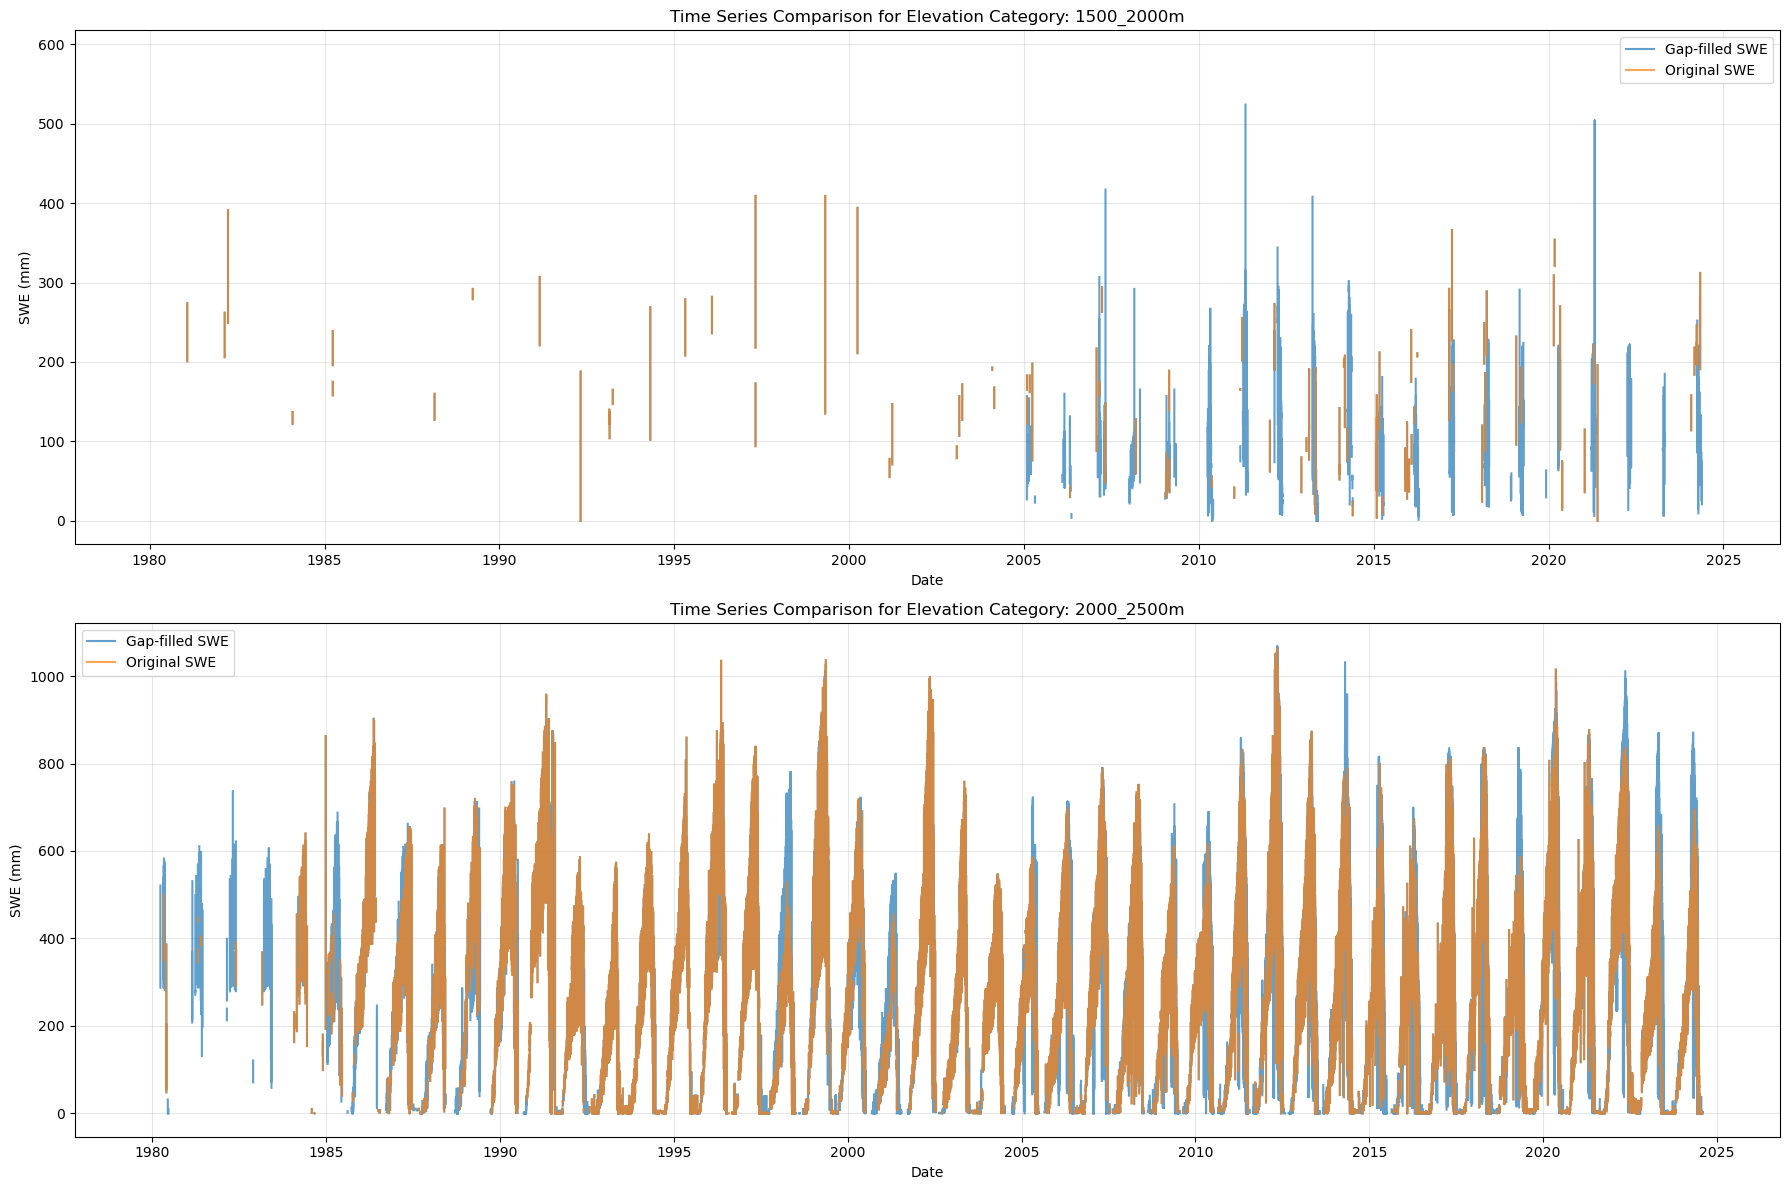

In [5]:
# Plot time series for each elevation category comparing Original_SWE and Gap_filled_SWE
elev_categories = [ '1500_2000m', '2000_2500m']

plt.figure(figsize=(18, 12))
for i, elev_cat in enumerate(elev_categories, 1):
    plt.subplot(len(elev_categories), 1, i)

    # Filter data for the current elevation category and sort by time
    df_cat = combined_canswe.loc[combined_canswe['Elevation_Category'] == elev_cat].sort_values('time')

    # Plot Gap-filled SWE (x and y have matching lengths)
    plt.plot(
        df_cat['time'],
        df_cat['Gap_Filled_CanSWE'],
        label='Gap-filled SWE',
        color='tab:blue',
        alpha=0.7
    )

    # Plot Original SWE (x and y have matching lengths)
    plt.plot(
        df_cat['time'],
        df_cat['Original_CanSWE'],
        label='Original SWE',
        color='tab:orange',
        alpha=0.7
    )

    plt.title(f'Time Series Comparison for Elevation Category: {elev_cat}')
    plt.xlabel('Date')
    plt.ylabel('SWE (mm)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Select data for the season
1. Winter months November to April data are selected

In [6]:
# Enforce allowed seasonal-year range inside the selector
def select_seasonal_data(ts, start_month, end_month, min_year, max_year):
    month = ts.month
    year = ts.year
    if month >= start_month:
        seasonal_year = year
    elif month <= end_month:
        seasonal_year = year - 1
    else:
        return np.nan
    return seasonal_year if (min_year <= seasonal_year <= max_year) else np.nan

# For CanSWE data
combined_canswe['Seasonal_Year'] = combined_canswe['time'].apply(
    lambda ts: select_seasonal_data(ts, start_month=10, end_month=5, min_year=1980, max_year=2023)
)

# Remove rows where Seasonal_Year is NaN (outside the allowed data range)
combined_canswe = combined_canswe.dropna(subset=['Seasonal_Year'])

# Save the final combined CanSWE data with Seasonal_Year column
#combined_canswe.to_csv(output_dir / 'bow_combined_canswe_gapfilled_data_with_seasonal_year.csv', index=False)

# Display final combined CanSWE data
display(combined_canswe)

,station_id,time,lat,lon,elevation,Original_CanSWE,Gap_Filled_CanSWE,Elevation_Category,Seasonal_Year
19267,ALE-05BA811,1980-10-01,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m,1980.0
19268,ALE-05BA811,1980-10-02,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m,1980.0
19269,ALE-05BA811,1980-10-03,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m,1980.0
19270,ALE-05BA811,1980-10-04,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m,1980.0
19271,ALE-05BA811,1980-10-05,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m,1980.0
...,...,...,...,...,...,...,...,...,...
2751540,ALE-05CA805P,2024-05-27,51.542156,-116.060966,2120.0,181.0,181.0,2000_2500m,2023.0
2751541,ALE-05CA805P,2024-05-28,51.542156,-116.060966,2120.0,159.0,159.0,2000_2500m,2023.0
2751542,ALE-05CA805P,2024-05-29,51.542156,-116.060966,2120.0,144.0,144.0,2000_2500m,2023.0
2751543,ALE-05CA805P,2024-05-30,51.542156,-116.060966,2120.0,138.0,138.0,2000_2500m,2023.0


In [7]:
# For CaSR data
casr_data['Seasonal_Year'] = casr_data['time'].apply(
    lambda ts: select_seasonal_data(ts, start_month=10, end_month=5, min_year=1980, max_year=2023)
)
# Remove rows where Seasonal_Year is NaN (outside the allowed data range)
casr_data = casr_data.dropna(subset=['Seasonal_Year'])
#save the final CaSR data with Seasonal_Year column
#casr_data.to_csv(output_dir / 'bow_casr_data_with_seasonal_year.csv', index=False)

# Display final CaSR data
display(casr_data)

,time,Grid_id,lon,lat,SWE,Precipitation,Elevation_Category,Seasonal_Year
0,1980-10-10,1,-116.1380,51.3346,0.878418,0.009879,2000_2500m,1980.0
2,1983-10-12,2,-116.1875,51.4191,6.875000,0.023846,2000_2500m,1983.0
3,1980-12-11,2,-116.1875,51.4191,118.125000,4.578907,2000_2500m,1980.0
5,1982-10-29,2,-116.1875,51.4191,23.125000,1.777088,2000_2500m,1982.0
6,1982-01-18,2,-116.1875,51.4191,145.000000,1.890419,2000_2500m,1981.0
...,...,...,...,...,...,...,...,...
4224297,2024-02-22,257,-111.6202,50.0960,6.250000,0.011239,500_1000m,2023.0
4224298,2024-03-19,257,-111.6202,50.0960,0.000488,0.000257,500_1000m,2023.0
4224301,2024-01-06,257,-111.6202,50.0960,0.625000,0.135581,500_1000m,2023.0
4224302,2024-05-17,257,-111.6202,50.0960,0.000000,6.328213,500_1000m,2023.0


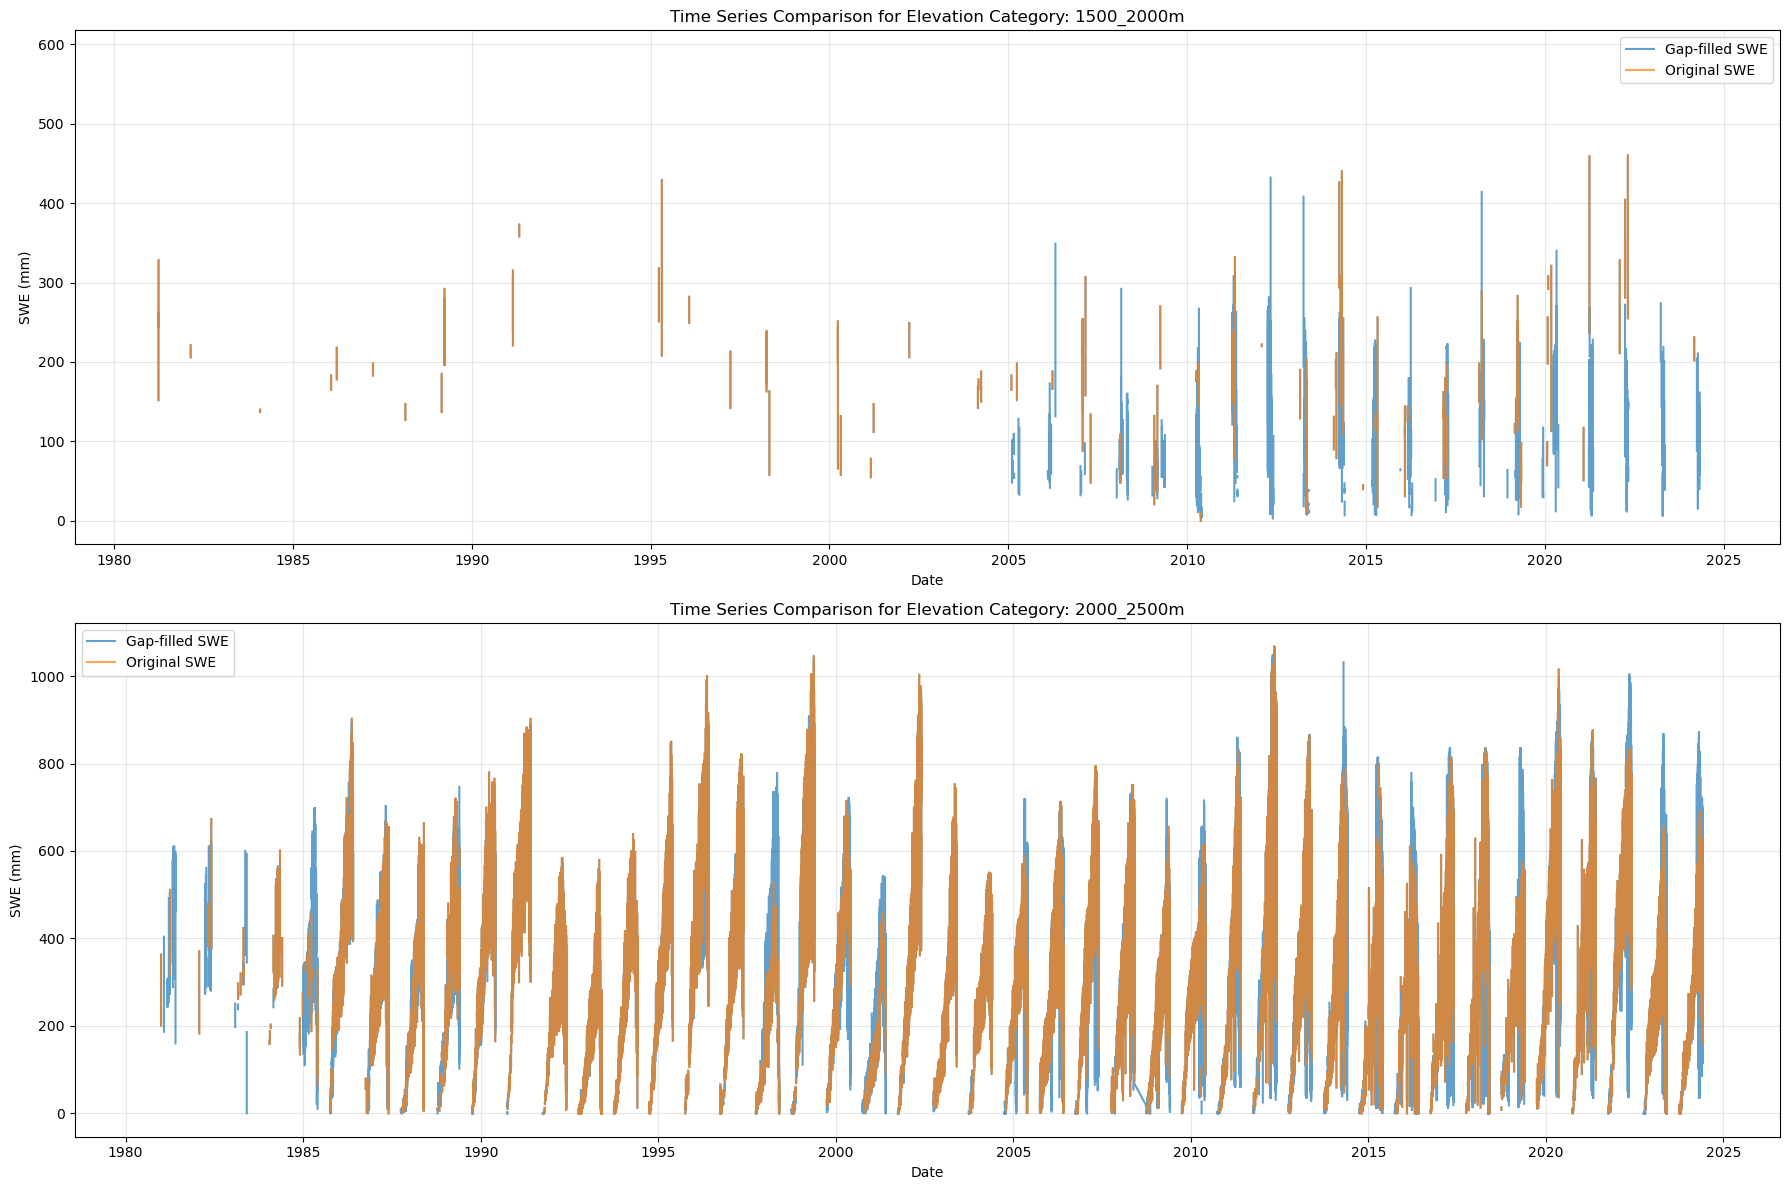

In [8]:
# Plot time series for each elevation category comparing Original_SWE and Gap_filled_SWE
elev_categories = [ '1500_2000m', '2000_2500m']

plt.figure(figsize=(18, 12))
for i, elev_cat in enumerate(elev_categories, 1):
    plt.subplot(len(elev_categories), 1, i)

    # Filter data for the current elevation category and sort by time
    df_cat = combined_canswe.loc[combined_canswe['Elevation_Category'] == elev_cat].sort_values('time')

    # Plot Gap-filled SWE (x and y have matching lengths)
    plt.plot(
        df_cat['time'],
        df_cat['Gap_Filled_CanSWE'],
        label='Gap-filled SWE',
        color='tab:blue',
        alpha=0.7
    )

    # Plot Original SWE (x and y have matching lengths)
    plt.plot(
        df_cat['time'],
        df_cat['Original_CanSWE'],
        label='Original SWE',
        color='tab:orange',
        alpha=0.7
    )

    plt.title(f'Time Series Comparison for Elevation Category: {elev_cat}')
    plt.xlabel('Date')
    plt.ylabel('SWE (mm)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate SWEI

Functions

In [9]:

def extract_grid_metadata(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract per-Grid static metadata.
    """
    return (
        df[["Grid_id", "lon", "lat", "Elevation_Category"]]
        .drop_duplicates("Grid_id")
        .set_index("Grid_id")
    )


def daily_to_monthly_swe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Daily SWE → monthly integrated SWE.
    Seasonal_Year is recomputed from time.
    """
    out = df.copy()
    out["time"] = pd.to_datetime(out["time"])

    monthly = (
        out
        .groupby(
            ["Grid_id", pd.Grouper(key="time", freq="MS")],
            as_index=False
        )
        .agg(
            SWE_monthly=("SWE", "sum")
        )
    )

    # Recompute Seasonal_Year (e.g., Oct–Sep water year)
    monthly["Seasonal_Year"] = np.where(
        monthly["time"].dt.month >= 10,
        monthly["time"].dt.year,
        monthly["time"].dt.year - 1
    )

    return monthly



def rolling_integrated_swe_by_season(
    monthly_df: pd.DataFrame,
    window_months: int
) -> pd.DataFrame:
    """
    Compute rolling k‑month integrated SWE within each Seasonal_Year.

    • Rolling windows do NOT cross Seasonal_Year boundaries.
    • First (k‑1) months of each season are dropped.
    • Works for any window (3, 6, 8, …).
    """

    out = monthly_df.copy()
    out = out.sort_values(["Grid_id", "Seasonal_Year", "time"])

    out[f"SWE_{window_months}mo"] = (
        out
        .groupby(["Grid_id", "Seasonal_Year"])["SWE_monthly"]
        .rolling(window=window_months, min_periods=window_months)
        .sum()
        .reset_index(level=[0, 1], drop=True)
    )

    return out.dropna(subset=[f"SWE_{window_months}mo"])



def gringorten_probabilities(x: np.ndarray) -> np.ndarray:
    """
    Gringorten plotting position with:
    - NaN handling
    - average ranks for ties
    - probability clipping
    """
    x = np.asarray(x, float)
    out = np.full_like(x, np.nan)

    mask = ~np.isnan(x)
    xv = x[mask]

    if xv.size == 0:
        return out

    # ranks with average ties
    order = np.argsort(xv, kind="mergesort")
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(xv) + 1)

    uvals, inv, cnt = np.unique(xv, return_inverse=True, return_counts=True)
    for i, c in enumerate(cnt):
        if c > 1:
            idx = np.where(inv == i)[0]
            ranks[idx] = ranks[idx].mean()

    N = float(len(xv))
    p = (ranks - 0.44) / (N + 0.12)
    p = np.clip(p, 1e-12, 1 - 1e-12)

    out[mask] = p
    return out


def compute_swei_for_grid(
    df: pd.DataFrame,
    swe_col: str,
    nonzero_frac_threshold: float = 0.75
) -> pd.DataFrame:
    """
    Compute SWEI for ONE Grid_id using calendar-month standardization.
    """
    out = df.copy()
    out["month"] = out["time"].dt.month

    pvals = np.full(len(out), np.nan)
    zvals = np.full(len(out), np.nan)

    for m in range(1, 13):
        idx = out["month"] == m
        vals = out.loc[idx, swe_col]

        valid = vals.notna()
        if valid.sum() == 0:
            continue

        frac_nonzero = (vals[valid] > 0).mean()
        if frac_nonzero < nonzero_frac_threshold:
            continue  # Near-normal (NN)

        p = gringorten_probabilities(vals.values)
        z = norm.ppf(p)

        pvals[idx] = p
        zvals[idx] = z

    out["Gringorten_p"] = pvals
    out["SWEI"] = zvals
    return out



def compute_swei(
    df: pd.DataFrame,
    window_months: int = 3
) -> pd.DataFrame:
    """
    End‑to‑end SWEI calculation with metadata preservation.
    """

    # 0. Extract static grid metadata
    grid_meta = extract_grid_metadata(df)

    # 1. Daily → monthly SWE
    monthly = daily_to_monthly_swe(df)

    # 2. Rolling integration
    integ = rolling_integrated_swe_by_season(monthly, window_months)

    # 3. Compute SWEI per grid
    swei = (
        integ
        .groupby("Grid_id", group_keys=False)
        .apply(
            lambda g: compute_swei_for_grid(
                g,
                swe_col=f"SWE_{window_months}mo"
            )
        )
    )

    # 4. Reattach static metadata
    swei = swei.join(grid_meta, on="Grid_id")

    return swei


def plot_seasonal_sswei_maps(
    swei_df,
    basin_gdf,
    config,
    window_label="3-month",
    swei_col="Avg_SWEI_3mo",
    start_year=1980,
    end_year=2024,
    month_order=(10, 11, 12, 1, 2, 3, 4, 5),
    month_names=None,
    classify_func=None,
    severity_colors=None,
    nrows=2,
    ncols=3,
    figsize=(20, 10),
    dpi=300
):
    """
    Plot seasonal SSWEI maps for each Seasonal_Year.

    Parameters
    ----------
    swei_df : pandas.DataFrame
        DataFrame containing SSWEI values with columns:
        ['Seasonal_Year', 'month', 'Elevation_Category', swei_col].
    basin_gdf : geopandas.GeoDataFrame
        Basin polygons with elevation categories column 'elev_class'.
    config : dict
        Configuration dictionary containing output directory path:
        config['SWEI_plots'].
    window_label : str
        Text label for SWEI window (e.g., '3-month', '6-month', '8-month').
    swei_col : str
        Column name containing SSWEI values.
    start_year, end_year : int
        Seasonal_Year range to plot (end_year is exclusive).
    month_order : iterable
        Ordered months for snow season (default Oct–May).
    month_names : dict
        Mapping of month number → month name.
    classify_func : callable
        Function that maps SSWEI → drought class.
    severity_colors : dict
        Mapping of drought class → color.
    nrows, ncols : int
        Subplot grid dimensions.
    figsize : tuple
        Figure size.
    dpi : int
        Output resolution.
    """

    if month_names is None:
        month_names = {
            1: "January", 2: "February", 3: "March", 4: "April",
            5: "May", 10: "October", 11: "November", 12: "December"
        }

    if classify_func is None or severity_colors is None:
        raise ValueError("Both classify_func and severity_colors must be provided.")

    for season_year in range(start_year, end_year):

        # Subset data for this season
        swei_year = swei_df[swei_df["Seasonal_Year"] == season_year]
        if swei_year.empty:
            continue

        # Determine months present and in correct order
        available_months = swei_year["month"].unique().tolist()
        months_year = [m for m in month_order if m in available_months]
        n_months = len(months_year)

        # Create subplot grid
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        axes = axes.flatten()

        for idx, month in enumerate(months_year):
            ax = axes[idx]

            # Subset month data
            month_data = swei_year[swei_year["month"] == month]

            # Prepare elevation-band SSWEI table
            sswei_long = (
                month_data[["Elevation_Category", swei_col]]
                .rename(columns={swei_col: "SSWEI"})
            )

            # Merge with basin geometry
            basin_plot = basin_gdf.merge(
                sswei_long,
                left_on="elev_class",
                right_on="Elevation_Category",
                how="left"
            )

            # Classify SSWEI and assign colors
            basin_plot["Drought_Classification"] = (
                basin_plot["SSWEI"].apply(classify_func)
            )
            basin_plot["color"] = (
                basin_plot["Drought_Classification"]
                .map(severity_colors)
                .fillna("#dddddd")
            )

            # Plot
            basin_plot.plot(
                ax=ax,
                color=basin_plot["color"],
                edgecolor="black",
                linewidth=0.5
            )

            # Display year logic
            display_year = season_year if month >= 10 else season_year + 1

            ax.set_title(
                f"{month_names.get(month, str(month))} {display_year}",
                fontsize=12,
                fontweight="bold"
            )
            ax.axis("off")

        # Hide unused axes
        for j in range(n_months, len(axes)):
            axes[j].set_visible(False)

        # Figure title and legend
        fig.suptitle(
            f"{window_label} SSWEI Distribution across Bow River Basin "
            f"(Season {season_year})",
            fontsize=16,
            fontweight="bold",
            y=0.98
        )

        legend_handles = [
            mpatches.Patch(color=c, label=l)
            for l, c in severity_colors.items()
        ]
        fig.legend(
            handles=legend_handles,
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            title="Drought Severity"
        )

        plt.tight_layout()

        # Save output
        out_file = (
            config["SWEI_plots"]
            / f"SSWEI_bow_basin_monthly_{window_label.replace(' ', '_')}_{season_year}.png"
        )
        fig.savefig(out_file, dpi=dpi, bbox_inches="tight")
        plt.close(fig)



1-Month SWEI

In [10]:
# 1-month SWEI
swei_1mo = compute_swei(casr_data, window_months=1)
swei_1mo_output_dir = config['SWEI_output_dir'] 
swei_1mo_output_dir.mkdir(parents=True, exist_ok=True)
swei_1mo.to_csv(swei_1mo_output_dir / 'bow_casr_swei_1mo.csv', index=False)

display(swei_1mo.head())

,Grid_id,time,SWE_monthly,Seasonal_Year,SWE_1mo,month,Gringorten_p,SWEI,lon,lat,Elevation_Category
0,1,1980-10-01,206.20874,1980,206.20874,10,0.262013,-0.637153,-116.138,51.3346,2000_2500m
1,1,1980-11-01,1297.43750,1980,1297.43750,11,0.511333,0.028411,-116.138,51.3346,2000_2500m
2,1,1980-12-01,3418.97217,1980,3418.97217,12,0.873980,1.145409,-116.138,51.3346,2000_2500m
3,1,1981-01-01,4229.06250,1980,4229.06250,1,0.647325,0.378110,-116.138,51.3346,2000_2500m
4,1,1981-02-01,4490.93750,1980,4490.93750,2,0.443336,-0.142516,-116.138,51.3346,2000_2500m


In [11]:
# avaerage SWEI over the Elevation categories, month and seasonal year
swei_1mo_avg = (
    swei_1mo
    .groupby(
        ['Elevation_Category', 'Seasonal_Year', 'month'],
        as_index=False
    )
    .agg(
        Avg_SWEI_1mo=('SWEI', 'mean')
    )
)

display(swei_1mo_avg)

,Elevation_Category,Seasonal_Year,month,Avg_SWEI_1mo
0,1000_1500m,1980,1,-1.573456
1,1000_1500m,1980,2,-0.754661
2,1000_1500m,1980,3,-1.294272
3,1000_1500m,1980,4,-0.979583
4,1000_1500m,1980,5,1.227319
...,...,...,...,...
1403,500_1000m,2023,4,0.266537
1404,500_1000m,2023,5,0.536958
1405,500_1000m,2023,10,1.030850
1406,500_1000m,2023,11,-0.990671


In [12]:
# extract 2023 seasonal year data
swei_1mo_2023 = swei_1mo_avg[swei_1mo_avg['Seasonal_Year'] == 2023]
display(swei_1mo_2023)

,Elevation_Category,Seasonal_Year,month,Avg_SWEI_1mo
344,1000_1500m,2023,1,0.237792
345,1000_1500m,2023,2,0.116545
346,1000_1500m,2023,3,0.718382
347,1000_1500m,2023,4,0.462958
348,1000_1500m,2023,5,0.676048
349,1000_1500m,2023,10,0.968895
350,1000_1500m,2023,11,-0.763666
351,1000_1500m,2023,12,-0.442060
696,1500_2000m,2023,1,0.837143
697,1500_2000m,2023,2,1.255874


In [ ]:
# Plot monthly SSWEI on bow basin subplots

# Desired month order: October (10) to May (5)
month_order = [10, 11, 12, 1, 2, 3, 4, 5]
# Keep only months that actually exist in the data, in the desired order
available_months = swei_1mo_2023['month'].unique().tolist()
months = [m for m in month_order if m in available_months]

n_months = len(months)

# Create subplot grid (2 rows x 4 columns for up to 8 months)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Define a color map for drought severity (keys match classify_sswei output)
severity_colors_SWEI = {
    'Exceptional Drought': '#800026',
    'Extreme Drought': '#BD0026',
    'Severe Drought': '#E31A1C',
    'Moderate Dry': '#FD8D3C',
    'Abnaormally Dry': '#FED976',
    'Near Normal': '#FFFFCC',
    'Abnormally Wet': '#C7E9B4',
    'Moderate Wet': '#7FCDBB',
    'Severe Wet': '#41B6C4',
    'Extreme Wet': '#225EA8',
    'Extremely Wet': '#0C2C84',
    'No Data': '#dddddd'
}

# Create a classification function for SSWEI values
# (same thresholds as before)
def classify_sswei(value):
    if pd.isna(value):
        return 'No Data'
    elif value <= -2.0:
        return 'Exceptional Drought'
    elif value < -1.6:
        return 'Extreme Drought'
    elif value < -1.3:
        return 'Severe Drought'
    elif value < -0.8:
        return 'Moderate Dry'
    elif value < -0.5:
        return 'Abnaormally Dry'
    elif value < 0.5:
        return 'Near Normal'
    elif value < 0.8:
        return 'Abnormally Wet'
    elif value < 1.3:
        return 'Moderate Wet'
    elif value < 1.6:
        return 'Severe Wet'
    elif value < 2.0:
        return 'Extreme Wet'
    else:
        return 'Extremely Wet'

# Initialize color column (will be updated per month in the loop)
bow_basin['color'] = '#dddddd'

# Month names for titles
month_names = {10: 'October', 11: 'November', 12: 'December',
               1: 'January', 2: 'February', 3: 'March',
               4: 'April', 5: 'May'}

# Plot each month
for season_year in range(1980, 2024):
    # SSWEI data for this season
    swei_year = swei_1mo_avg[swei_1mo_avg['Seasonal_Year'] == season_year]

    # Months available for this season, in desired order
    available_months = swei_year['month'].unique().tolist()
    months_year = [m for m in month_order if m in available_months]
    n_months_year = len(months_year)

    # Create subplot grid (2 rows x 4 columns for up to 8 months)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for idx, month in enumerate(months_year):
        ax = axes[idx]

        # Subset SSWEI for this month and season
        month_data = swei_year[swei_year['month'] == month].copy()

        # One row per elevation band; just select and rename
        month_data_long = month_data[['Elevation_Category', 'Avg_SWEI_1mo']].copy()
        month_data_long = month_data_long.rename(columns={'Avg_SWEI_1mo': 'SSWEI'})

        # Merge SSWEI values with basin geometry using elevation categories
        basin_plot = bow_basin.merge(
            month_data_long[['Elevation_Category', 'SSWEI']],
            left_on='elev_class',
            right_on='Elevation_Category',
            how='left'
        )

        # Classify SSWEI values and assign colors
        basin_plot['Drought_Classification'] = basin_plot['SSWEI'].apply(classify_sswei)
        basin_plot['color'] = basin_plot['Drought_Classification'].map(severity_colors_SWEI).fillna('#dddddd')

        # Plot the basin with SSWEI values
        basin_plot.plot(ax=ax, color=basin_plot['color'], edgecolor='black', linewidth=0.5)

        # Calendar year for the given month in this snow season
        display_year = season_year if month >= 10 else season_year + 1
        ax.set_title(f"{month_names.get(month, str(month))} {display_year}",
                     fontsize=12, fontweight='bold')
        ax.axis('off')

    # Hide any unused subplots (if fewer than 8 months)
    for j in range(n_months_year, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f'Monthly SSWEI Distribution across Bow River Basin (Season {season_year})',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.legend(handles=[mpatches.Patch(color=color, label=label)
                        for label, color in severity_colors_SWEI.items()],
               bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0., title='Drought Severity')
    plt.tight_layout()

    # Save figure for this season
    #out_file_map = config['SWEI_plots'] / f'SSWEI_bow_basin_monthly_{season_year}.png'
    #fig.savefig(out_file_map, dpi=300, bbox_inches='tight')
   # plt.show()

3 - Month SWEI

In [14]:
# 3-month SWEI
swei_3mo = compute_swei(casr_data, window_months=3)
swei_3mo_output_dir = config['SWEI_output_dir'] 
swei_3mo_output_dir.mkdir(parents=True, exist_ok=True)
swei_3mo.to_csv(swei_3mo_output_dir / 'bow_casr_swei_3mo.csv', index=False)

display(swei_3mo)

,Grid_id,time,SWE_monthly,Seasonal_Year,SWE_3mo,month,Gringorten_p,SWEI,lon,lat,Elevation_Category
2,1,1980-12-01,3418.972170,1980,4922.618410,12,0.737987,0.637153,-116.1380,51.3346,2000_2500m
3,1,1981-01-01,4229.062500,1980,8945.472170,1,0.715322,0.569000,-116.1380,51.3346,2000_2500m
4,1,1981-02-01,4490.937500,1980,12138.972170,2,0.647325,0.378110,-116.1380,51.3346,2000_2500m
5,1,1981-03-01,5416.625000,1980,14136.625000,3,0.466002,-0.085324,-116.1380,51.3346,2000_2500m
6,1,1981-04-01,6174.931640,1980,16082.494140,4,0.443336,-0.142516,-116.1380,51.3346,2000_2500m
...,...,...,...,...,...,...,...,...,...,...,...
90459,257,2024-01-01,188.628906,2023,215.202453,1,0.171351,-0.948841,-111.6202,50.0960,500_1000m
90460,257,2024-02-01,147.339844,2023,351.277984,2,0.375340,-0.317743,-111.6202,50.0960,500_1000m
90461,257,2024-03-01,228.636963,2023,564.605712,3,0.579329,0.200177,-111.6202,50.0960,500_1000m
90462,257,2024-04-01,33.114258,2023,409.091064,4,0.715322,0.569000,-111.6202,50.0960,500_1000m


In [15]:
# avaerage SWEI over the Elevation categories, month and seasonal year
swei_3mo_avg = (
    swei_3mo
    .groupby(
        ['Elevation_Category', 'Seasonal_Year','month'],
        as_index=False
    )
    .agg(
        Avg_SWEI_3mo=('SWEI', 'mean')
    )
)

display(swei_3mo_avg.head(15))

,Elevation_Category,Seasonal_Year,month,Avg_SWEI_3mo
0,1000_1500m,1980,1,-0.002038
1,1000_1500m,1980,2,-0.254388
2,1000_1500m,1980,3,-2.022103
3,1000_1500m,1980,4,-1.538498
4,1000_1500m,1980,5,-1.075890
5,1000_1500m,1980,12,0.403853
6,1000_1500m,1981,1,-0.255568
7,1000_1500m,1981,2,0.421963
8,1000_1500m,1981,3,0.707197
9,1000_1500m,1981,4,0.858082


In [ ]:
# Plot each month
for season_year in range(1980, 2024):
    # SSWEI data for this season
    swei_year = swei_3mo_avg[swei_3mo_avg['Seasonal_Year'] == season_year]

    # Months available for this season, in desired order
    available_months = swei_year['month'].unique().tolist()
    months_year = [m for m in month_order if m in available_months]
    n_months_year = len(months_year)

    # Create subplot grid (2 rows x 3 columns for up to 6 months)
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()

    for idx, month in enumerate(months_year):
        ax = axes[idx]

        # Subset SSWEI for this month and season
        month_data = swei_year[swei_year['month'] == month].copy()

        # One row per elevation band; just select and rename
        month_data_long = month_data[['Elevation_Category', 'Avg_SWEI_3mo']].copy()
        month_data_long = month_data_long.rename(columns={'Avg_SWEI_3mo': 'SSWEI'})

        # Merge SSWEI values with basin geometry using elevation categories
        basin_plot = bow_basin.merge(
            month_data_long[['Elevation_Category', 'SSWEI']],
            left_on='elev_class',
            right_on='Elevation_Category',
            how='left'
        )

        # Classify SSWEI values and assign colors
        basin_plot['Drought_Classification'] = basin_plot['SSWEI'].apply(classify_sswei)
        basin_plot['color'] = basin_plot['Drought_Classification'].map(severity_colors_SWEI).fillna('#dddddd')

        # Plot the basin with SSWEI values
        basin_plot.plot(ax=ax, color=basin_plot['color'], edgecolor='black', linewidth=0.5)

        # Calendar year for the given month in this snow season
        display_year = season_year if month >= 10 else season_year + 1
        ax.set_title(f"{month_names.get(month, str(month))} {display_year}",
                     fontsize=12, fontweight='bold')
        ax.axis('off')

    # Hide any unused subplots (if fewer than 8 months)
    for j in range(n_months_year, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f'3-month SSWEI Distribution across Bow River Basin (Season {season_year})',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.legend(handles=[mpatches.Patch(color=color, label=label)
                        for label, color in severity_colors_SWEI.items()],
               bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0., title='Drought Severity')
    plt.tight_layout()

    # Save figure for this season
    #out_file_map = config['SWEI_plots'] / f'SSWEI_bow_basin_monthly_{season_year}.png'
    #fig.savefig(out_file_map, dpi=300, bbox_inches='tight')
   # plt.show()

Seasonal SWEI - 8 months

In [17]:
# 8-month SWEI
swei_8mo = compute_swei(casr_data, window_months=8)
swei_8mo_output_dir = config['SWEI_output_dir'] 
swei_8mo_output_dir.mkdir(parents=True, exist_ok=True)
swei_8mo.to_csv(swei_8mo_output_dir / 'bow_casr_swei_8mo.csv', index=False)

display(swei_8mo)

,Grid_id,time,SWE_monthly,Seasonal_Year,SWE_8mo,month,Gringorten_p,SWEI,lon,lat,Elevation_Category
7,1,1981-05-01,5072.800764,1980,30306.975814,5,0.556664,0.142516,-116.1380,51.3346,2000_2500m
15,1,1982-05-01,7276.954120,1981,34493.079364,5,0.737987,0.637153,-116.1380,51.3346,2000_2500m
23,1,1983-05-01,5607.820307,1982,34208.649527,5,0.692656,0.503394,-116.1380,51.3346,2000_2500m
31,1,1984-05-01,5777.537110,1983,28006.298830,5,0.420671,-0.200177,-116.1380,51.3346,2000_2500m
39,1,1985-05-01,4583.076164,1984,26935.667961,5,0.352675,-0.378110,-116.1380,51.3346,2000_2500m
...,...,...,...,...,...,...,...,...,...,...,...
90431,257,2020-05-01,0.000000,2019,584.591553,5,0.284678,-0.569000,-111.6202,50.0960,500_1000m
90439,257,2021-05-01,11.372070,2020,579.107177,5,0.239347,-0.708404,-111.6202,50.0960,500_1000m
90447,257,2022-05-01,0.000000,2021,283.044342,5,0.012693,-2.235488,-111.6202,50.0960,500_1000m
90455,257,2023-05-01,0.000000,2022,743.058776,5,0.466002,-0.085324,-111.6202,50.0960,500_1000m


In [18]:
# avaerage SWEI over the Elevation categories, month and seasonal year
swei_8mo_avg = (
    swei_8mo
    .groupby(
        ['Elevation_Category', 'Seasonal_Year','month'],
        as_index=False
    )
    .agg(
        Avg_SWEI_8mo=('SWEI', 'mean')
    )
)

display(swei_8mo_avg.head(15))

,Elevation_Category,Seasonal_Year,month,Avg_SWEI_8mo
0,1000_1500m,1980,5,-0.778473
1,1000_1500m,1981,5,0.320094
2,1000_1500m,1982,5,-0.942805
3,1000_1500m,1983,5,-0.356098
4,1000_1500m,1984,5,-0.147442
5,1000_1500m,1985,5,0.314323
6,1000_1500m,1986,5,-0.474813
7,1000_1500m,1987,5,-1.338402
8,1000_1500m,1988,5,0.898300
9,1000_1500m,1989,5,0.113604


In [ ]:
# Plot each month
for season_year in range(1980, 2024):
    # SSWEI data for this season
    swei_year = swei_8mo_avg[swei_8mo_avg['Seasonal_Year'] == season_year]

    # Months available for this season, in desired order
    available_months = swei_year['month'].unique().tolist()
    months_year = [m for m in month_order if m in available_months]
    n_months_year = len(months_year)

    # Create subplot grid (1 rows x 1 columns for up to 6 months)
    fig, axes = plt.subplots(1, 1, figsize=(20, 10))
    axes = np.atleast_1d(axes).ravel()

    for idx, month in enumerate(months_year):
        ax = axes[idx]

        # Subset SSWEI for this month and season
        month_data = swei_year[swei_year['month'] == month].copy()

        # One row per elevation band; just select and rename
        month_data_long = month_data[['Elevation_Category', 'Avg_SWEI_8mo']].copy()
        month_data_long = month_data_long.rename(columns={'Avg_SWEI_8mo': 'SSWEI'})

        # Merge SSWEI values with basin geometry using elevation categories
        basin_plot = bow_basin.merge(
            month_data_long[['Elevation_Category', 'SSWEI']],
            left_on='elev_class',
            right_on='Elevation_Category',
            how='left'
        )

        # Classify SSWEI values and assign colors
        basin_plot['Drought_Classification'] = basin_plot['SSWEI'].apply(classify_sswei)
        basin_plot['color'] = basin_plot['Drought_Classification'].map(severity_colors_SWEI).fillna('#dddddd')

        # Plot the basin with SSWEI values
        basin_plot.plot(ax=ax, color=basin_plot['color'], edgecolor='black', linewidth=0.5)

        # Calendar year for the given month in this snow season
        #display_year = season_year if month >= 10 else season_year + 1
        #ax.set_title(f"{month_names.get(month, str(month))} {display_year}",
        #             fontsize=12, fontweight='bold')
        ax.axis('off')

    # Hide any unused subplots (if fewer than 8 months)
    for j in range(n_months_year, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f'8-month SSWEI Distribution across Bow River Basin (Season {season_year})',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.legend(handles=[mpatches.Patch(color=color, label=label)
                        for label, color in severity_colors_SWEI.items()],
               bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0., title='Drought Severity')
    plt.tight_layout()

    # Save figure for this season
    #out_file_map = config['SWEI_plots'] / f'SSWEI_bow_basin_8month_{season_year}.png'
    #fig.savefig(out_file_map, dpi=300, bbox_inches='tight')
   # plt.show()

# SPI Calculations

In [26]:
# load percipitation data and compute SPI 
precip_data = casr_data[['time', 'Grid_id','lon', 'lat', 'Precipitation', 'Elevation_Category']].copy()
precip_data['time'] = pd.to_datetime(precip_data['time'])
precip_data['month'] = precip_data['time'].dt.month
display(precip_data.head())

,time,Grid_id,lon,lat,Precipitation,Elevation_Category,month
0,1980-10-10,1,-116.1380,51.3346,0.009879,2000_2500m,10
2,1983-10-12,2,-116.1875,51.4191,0.023846,2000_2500m,10
3,1980-12-11,2,-116.1875,51.4191,4.578907,2000_2500m,12
5,1982-10-29,2,-116.1875,51.4191,1.777088,2000_2500m,10
6,1982-01-18,2,-116.1875,51.4191,1.890419,2000_2500m,1


Functions

In [34]:
def extract_grid_metadata(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract per-Grid static metadata.
    """
    return (
        df[["Grid_id", "lon", "lat", "Elevation_Category"]]
        .drop_duplicates("Grid_id")
        .set_index("Grid_id")
    )


def daily_to_monthly_precipitation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Daily precipitation → monthly integrated precipitation.
    Seasonal_Year is recomputed from time.
    """
    out = df.copy()
    out["time"] = pd.to_datetime(out["time"])

    monthly = (
        out
        .groupby(
            ["Grid_id", pd.Grouper(key="time", freq="MS")],
            as_index=False
        )
        .agg(
            Precipitation_monthly=("Precipitation", "sum")
        )
    )

    # Recompute Seasonal_Year (e.g., Oct–Sep water year)
    monthly["Seasonal_Year"] = np.where(
        monthly["time"].dt.month >= 10,
        monthly["time"].dt.year,
        monthly["time"].dt.year - 1
    )

    return monthly



def rolling_integrated_precipitation_by_season(
    monthly_df: pd.DataFrame,
    window_months: int
) -> pd.DataFrame:
    """
    Compute rolling k‑month integrated precipitation within each Seasonal_Year.

    • Rolling windows do NOT cross Seasonal_Year boundaries.
    • First (k‑1) months of each season are dropped.
    • Works for any window (3, 6, 8, …).
    """

    out = monthly_df.copy()
    out = out.sort_values(["Grid_id", "Seasonal_Year", "time"])

    out[f"Precipitation_{window_months}mo"] = (
        out
        .groupby(["Grid_id", "Seasonal_Year"])["Precipitation_monthly"]
        .rolling(window=window_months, min_periods=window_months)
        .sum()
        .reset_index(level=[0, 1], drop=True)
    )

    return out.dropna(subset=[f"Precipitation_{window_months}mo"])


def calculate_spi(series: pd.Series, min_samples: int = 20) -> pd.Series:
    """
    Calculates SPI using a mixed Gamma distribution.
    """
    x = series.values

    # Probability of zero precipitation
    q = np.mean(x == 0)

    pos = x[x > 0]
    if len(pos) < min_samples:
        return pd.Series(np.nan, index=series.index)

    shape, loc, scale = gamma.fit(pos, floc=0)
    
    G = gamma.cdf(x, shape, loc=loc, scale=scale)
    H = q + (1 - q) * G

    H = np.clip(H, 1e-6, 1 - 1e-6)

    spi = norm.ppf(H)

    return pd.Series(spi, index=series.index)



def compute_spi_for_grids(
    precip_df: pd.DataFrame,
    precip_col: str
) -> pd.DataFrame:

    out = []

    for grid_id, gdf in precip_df.groupby("Grid_id"):
        gdf = gdf.sort_values("time")

        for month in range(1, 13):
            mask = gdf["time"].dt.month == month
            spi_series = calculate_spi(gdf.loc[mask, precip_col])

            gdf.loc[mask, "SPI"] = spi_series

        gdf["Grid_id"] = grid_id
        out.append(gdf)

    return pd.concat(out).sort_values(["Grid_id", "time"])


def spi_pipeline(
    daily_df: pd.DataFrame,
    window_months: int
) -> pd.DataFrame:

    # 1. Metadata
    grid_meta = extract_grid_metadata(daily_df)

    # 2. Daily → Monthly
    monthly = daily_to_monthly_precipitation(daily_df)

    # 3. Rolling integrated precipitation
    rolled = rolling_integrated_precipitation_by_season(
        monthly,
        window_months=window_months
    )

    precip_col = f"Precipitation_{window_months}mo"

    # 4. SPI calculation
    spi = compute_spi_for_grids(rolled, precip_col)

    # 5. Join metadata
    final = (
        spi
        .merge(grid_meta, left_on="Grid_id", right_index=True, how="left")
        .sort_values(["Grid_id", "time"])
    )
    final["month"] = final["time"].dt.month.astype("int32")

    return final

def classify_spi(spi):

    if spi <= -2.0:
        return "Extremely dry"
    elif spi <= -1.5:
        return "Severely dry"
    elif spi <= -1.0:
        return "Moderately dry"
    elif spi < 1.0:
        return "Near normal"
    elif spi < 1.5:
        return "Moderately wet"
    elif spi < 2.0:
        return "Severely wet"
    else:
        return "Extremely wet"

severity_colors_SPI = {
        'Extremely dry': '#800026',
        'Severely dry': '#E31A1C',
        'Moderately dry': '#FD8D3C',
        'Abnormally dry': '#FED976',
        'Near normal': '#FFFFCC',
        'Moderately wet': '#7FCDBB',
        'Severely wet': '#41B6C4',
        'Extremely wet': '#0C2C84',
        'No Data': '#dddddd'
}


In [29]:
# Compute SPI for 1-month, 3-month, and 8-month windows
spi_1  = spi_pipeline(precip_data, window_months=1)
spi_3  = spi_pipeline(precip_data, window_months=3)
spi_8  = spi_pipeline(precip_data, window_months=8)

# Save SPI results
spi_output_dir = config['SPI_output_dir']
spi_output_dir.mkdir(parents=True, exist_ok=True)
spi_1.to_csv(spi_output_dir / 'bow_casr_spi_1mo.csv', index=False)
spi_3.to_csv(spi_output_dir / 'bow_casr_spi_3mo.csv', index=False)
spi_8.to_csv(spi_output_dir / 'bow_casr_spi_8mo.csv', index=False)

display(spi_1.head())
display(spi_3.head())
display(spi_8.head())

c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\walimunige.rupasin

,Grid_id,time,Precipitation_monthly,Seasonal_Year,Precipitation_1mo,SPI,lon,lat,Elevation_Category,month
0,1,1980-10-01,15.461886,1980,15.461886,-1.719106,-116.138,51.3346,2000_2500m,10
1,1,1980-11-01,50.295086,1980,50.295086,-0.009262,-116.138,51.3346,2000_2500m,11
2,1,1980-12-01,108.955549,1980,108.955549,2.369988,-116.138,51.3346,2000_2500m,12
3,1,1981-01-01,13.916898,1980,13.916898,-1.682782,-116.138,51.3346,2000_2500m,1
4,1,1981-02-01,38.431036,1980,38.431036,0.397813,-116.138,51.3346,2000_2500m,2


,Grid_id,time,Precipitation_monthly,Seasonal_Year,Precipitation_3mo,SPI,lon,lat,Elevation_Category,month
2,1,1980-12-01,108.955549,1980,174.712521,0.549997,-116.138,51.3346,2000_2500m,12
3,1,1981-01-01,13.916898,1980,173.167533,0.663746,-116.138,51.3346,2000_2500m,1
4,1,1981-02-01,38.431036,1980,161.303483,1.010004,-116.138,51.3346,2000_2500m,2
5,1,1981-03-01,18.109773,1980,70.457707,-1.437296,-116.138,51.3346,2000_2500m,3
6,1,1981-04-01,36.249706,1980,92.790515,-0.500546,-116.138,51.3346,2000_2500m,4


,Grid_id,time,Precipitation_monthly,Seasonal_Year,Precipitation_8mo,SPI,lon,lat,Elevation_Category,month
7,1,1981-05-01,49.272601,1980,330.692535,-0.405901,-116.138,51.3346,2000_2500m,5
15,1,1982-05-01,24.854834,1981,321.687604,-0.535996,-116.138,51.3346,2000_2500m,5
23,1,1983-05-01,25.470663,1982,231.587842,-1.999246,-116.138,51.3346,2000_2500m,5
31,1,1984-05-01,67.581612,1983,272.967472,-1.286302,-116.138,51.3346,2000_2500m,5
39,1,1985-05-01,44.867321,1984,258.220625,-1.531273,-116.138,51.3346,2000_2500m,5


In [31]:
# avaerage monthly SWEI over the Elevation categories, month and seasonal year
sweispi_1mo_avg = (
    spi_1
    .groupby(
        ['Elevation_Category', 'Seasonal_Year','month'],
        as_index=False
    )
    .agg(
        Avg_SWEI_1mo=('SPI', 'mean')
    )
)

display(sweispi_1mo_avg.head(15))

# avaerage 3-month SWEI over the Elevation categories, month and seasonal year
sweispi_3mo_avg = (
    spi_3
    .groupby(
        ['Elevation_Category', 'Seasonal_Year','month'],
        as_index=False
    )
    .agg(
        Avg_SWEI_3mo=('SPI', 'mean')
    )
)

display(sweispi_3mo_avg.head(15))

# avaerage 8-month SWEI over the Elevation categories, month and seasonal year
sweispi_8mo_avg = (
    spi_8
    .groupby(
        ['Elevation_Category', 'Seasonal_Year','month'],
        as_index=False
    )
    .agg(
        Avg_SWEI_8mo=('SPI', 'mean')
    )
)

display(sweispi_8mo_avg.head(15))

,Elevation_Category,Seasonal_Year,month,Avg_SWEI_1mo
0,1000_1500m,1980,1,-0.530882
1,1000_1500m,1980,2,-0.401207
2,1000_1500m,1980,3,-0.361803
3,1000_1500m,1980,4,-1.590158
4,1000_1500m,1980,5,1.654429
5,1000_1500m,1980,10,0.300076
6,1000_1500m,1980,11,0.591722
7,1000_1500m,1980,12,0.969271
8,1000_1500m,1981,1,0.397188
9,1000_1500m,1981,2,-0.276307


,Elevation_Category,Seasonal_Year,month,Avg_SWEI_3mo
0,1000_1500m,1980,1,0.555004
1,1000_1500m,1980,2,0.025304
2,1000_1500m,1980,3,-0.883538
3,1000_1500m,1980,4,-1.497327
4,1000_1500m,1980,5,0.928858
5,1000_1500m,1980,12,0.786710
6,1000_1500m,1981,1,-1.417469
7,1000_1500m,1981,2,-0.912163
8,1000_1500m,1981,3,0.404195
9,1000_1500m,1981,4,-0.291336


,Elevation_Category,Seasonal_Year,month,Avg_SWEI_8mo
0,1000_1500m,1980,5,0.814199
1,1000_1500m,1981,5,-0.394971
2,1000_1500m,1982,5,-0.728352
3,1000_1500m,1983,5,-1.105114
4,1000_1500m,1984,5,-1.615538
5,1000_1500m,1985,5,-0.523740
6,1000_1500m,1986,5,-2.081306
7,1000_1500m,1987,5,-2.430023
8,1000_1500m,1988,5,-0.778585
9,1000_1500m,1989,5,0.644117


In [ ]:
# Plot monthly SSWEI on bow basin subplots

# Desired month order: October (10) to May (5)
month_order = [10, 11, 12, 1, 2, 3, 4, 5]
# Keep only months that actually exist in the data, in the desired order
available_months = swei_1mo_2023['month'].unique().tolist()
months = [m for m in month_order if m in available_months]

n_months = len(months)

# Create subplot grid (2 rows x 4 columns for up to 8 months)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Define a color map for drought severity (keys match classify_sswei output)
severity_colors_SWEI = {
    'Exceptional Drought': '#800026',
    'Extreme Drought': '#BD0026',
    'Severe Drought': '#E31A1C',
    'Moderate Dry': '#FD8D3C',
    'Abnaormally Dry': '#FED976',
    'Near Normal': '#FFFFCC',
    'Abnormally Wet': '#C7E9B4',
    'Moderate Wet': '#7FCDBB',
    'Severe Wet': '#41B6C4',
    'Extreme Wet': '#225EA8',
    'Extremely Wet': '#0C2C84',
    'No Data': '#dddddd'
}

# Create a classification function for SSWEI values
# (same thresholds as before)
def classify_sswei(value):
    if pd.isna(value):
        return 'No Data'
    elif value <= -2.0:
        return 'Exceptional Drought'
    elif value < -1.6:
        return 'Extreme Drought'
    elif value < -1.3:
        return 'Severe Drought'
    elif value < -0.8:
        return 'Moderate Dry'
    elif value < -0.5:
        return 'Abnaormally Dry'
    elif value < 0.5:
        return 'Near Normal'
    elif value < 0.8:
        return 'Abnormally Wet'
    elif value < 1.3:
        return 'Moderate Wet'
    elif value < 1.6:
        return 'Severe Wet'
    elif value < 2.0:
        return 'Extreme Wet'
    else:
        return 'Extremely Wet'

# Initialize color column (will be updated per month in the loop)
bow_basin['color'] = '#dddddd'

# Month names for titles
month_names = {10: 'October', 11: 'November', 12: 'December',
               1: 'January', 2: 'February', 3: 'March',
               4: 'April', 5: 'May'}

# Plot each month
for season_year in range(1980, 2024):
    # SSWEI data for this season
    swei_year = swei_1mo_avg[swei_1mo_avg['Seasonal_Year'] == season_year]

    # Months available for this season, in desired order
    available_months = swei_year['month'].unique().tolist()
    months_year = [m for m in month_order if m in available_months]
    n_months_year = len(months_year)

    # Create subplot grid (2 rows x 4 columns for up to 8 months)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for idx, month in enumerate(months_year):
        ax = axes[idx]

        # Subset SSWEI for this month and season
        month_data = swei_year[swei_year['month'] == month].copy()

        # One row per elevation band; just select and rename
        month_data_long = month_data[['Elevation_Category', 'Avg_SWEI_1mo']].copy()
        month_data_long = month_data_long.rename(columns={'Avg_SWEI_1mo': 'SSWEI'})

        # Merge SSWEI values with basin geometry using elevation categories
        basin_plot = bow_basin.merge(
            month_data_long[['Elevation_Category', 'SSWEI']],
            left_on='elev_class',
            right_on='Elevation_Category',
            how='left'
        )

        # Classify SSWEI values and assign colors
        basin_plot['Drought_Classification'] = basin_plot['SSWEI'].apply(classify_sswei)
        basin_plot['color'] = basin_plot['Drought_Classification'].map(severity_colors_SWEI).fillna('#dddddd')

        # Plot the basin with SSWEI values
        basin_plot.plot(ax=ax, color=basin_plot['color'], edgecolor='black', linewidth=0.5)

        # Calendar year for the given month in this snow season
        display_year = season_year if month >= 10 else season_year + 1
        ax.set_title(f"{month_names.get(month, str(month))} {display_year}",
                     fontsize=12, fontweight='bold')
        ax.axis('off')

    # Hide any unused subplots (if fewer than 8 months)
    for j in range(n_months_year, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f'Monthly SSWEI Distribution across Bow River Basin (Season {season_year})',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.legend(handles=[mpatches.Patch(color=color, label=label)
                        for label, color in severity_colors_SWEI.items()],
               bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0., title='Drought Severity')
    plt.tight_layout()

    # Save figure for this season
    #out_file_map = config['SWEI_plots'] / f'SSWEI_bow_basin_monthly_{season_year}.png'
    #fig.savefig(out_file_map, dpi=300, bbox_inches='tight')
   # plt.show()